In [1]:
import xarray as xr
import pandas as pd
import numpy as np
from ntv_numpy import Xdataset
import ntv_pandas as npd
import cbor2



In [9]:
import matplotlib.pyplot as plt
import ntv_numpy
import cbor2

def file_sizes(xnd):
    '''calculate the size of each format'''
    df = xnd.to_dataframe(json_name=False, info=False).reset_index().sample(frac=1)
    return {'pd.to_json(values)': len(df.to_json(orient='values')),
            'pd.to_csv': len(df.to_csv()),
            'pd.to_parquet': len(df.to_parquet(engine='pyarrow')),
            'nxr.to_json': len(xnd.to_json(notype='all', header=False, encoded=True)),
            'nxr.to_json(cbor)': len(cbor2.dumps(xnd.to_json(notype='all', header=False, encoded=False)))}

def sizes_plot(sizes, titles, fig_title):
    '''plot the size of some format''' 
    fig, axs = plt.subplots(1, 4, figsize=(24, 6))
    fig.suptitle(fig_title)
    for idx, (size, title) in enumerate(zip(sizes, titles)):
        bar_colors = ['tab:red' if val == min(size.values()) else 'tab:blue' for val in size.values()]
        percent = [str(round(val / list(size.values())[1] * 100, 1)) + ' %' for val in size.values()]
        bar_plt = axs[idx].bar(size.keys(), size.values(), color=bar_colors)
        axs[idx].set_title(title)
        axs[idx].bar_label(bar_plt, percent, label_type='center')
        axs[idx].tick_params(axis='x', rotation=55)
    plt.show()

# multidimensional

In [10]:
xdss = [xr.Dataset({"var": (['a', 'b', 'c', 'd', 'e'], np.arange(100000).reshape(10, 10, 10, 10, 10))},
                    coords={"a": np.arange(10), "b": np.arange(10, 20), "c": np.arange(20, 30), "d": np.arange(30, 40), "e": np.arange(40, 50) }),
        xr.Dataset({"var": (['a', 'b', 'c', 'd', 'e'], np.arange(100000).reshape(10, 10, 10, 10, 10))},
                    coords={"a": np.array(['sdfghjsdfghj', 'dfghjkdfghjk', 'azertyazerty', 'zertyuzertyu', 'rtyuiortyuio', 
                                           'uiopqsuiopqs', 'qsdfghqsdfgh', 'ghjklmghjklm', 'wxcvbnwxcvbn', 'hjklmwhjklmw']),
                            "b": np.array(['uiopqsuiopqs', 'qsdfghqsdfgh', 'azertyazerty', 'zertyuzertyu', 'rtyuiortyuio',
                                           'sdfghjsdfghj', 'dfghjkdfghjk', 'wxcvbnwxcvbn', 'ghjklmghjklm', 'hjklmwhjklmw']),
                            "c": np.array(['dfghjkdfghjk', 'ghjklmghjklm', 'azertyazerty', 'uiopqsuiopqs', 'qsdfghqsdfgh', 
                                           'sdfghjsdfghj', 'wxcvbnwxcvbn', 'hjklmwhjklmw', 'zertyuzertyu', 'rtyuiortyuio']),
                            "d": np.array(['azertyazerty', 'zertyuzertyu', 'rtyuiortyuio', 'uiopqsuiopqs', 'qsdfghqsdfgh', 
                                           'sdfghjsdfghj', 'dfghjkdfghjk', 'ghjklmghjklm', 'wxcvbnwxcvbn', 'hjklmwhjklmw']),
                            "e": np.array(['qsdfghqsdfgh', 'sdfghjsdfghj', 'dfghjkdfghjk', 'ghjklmghjklm', 'wxcvbnwxcvbn',
                                           'hjklmwhjklmw', 'azertyazerty', 'zertyuzertyu', 'rtyuiortyuio', 'uiopqsuiopqs'])})
]


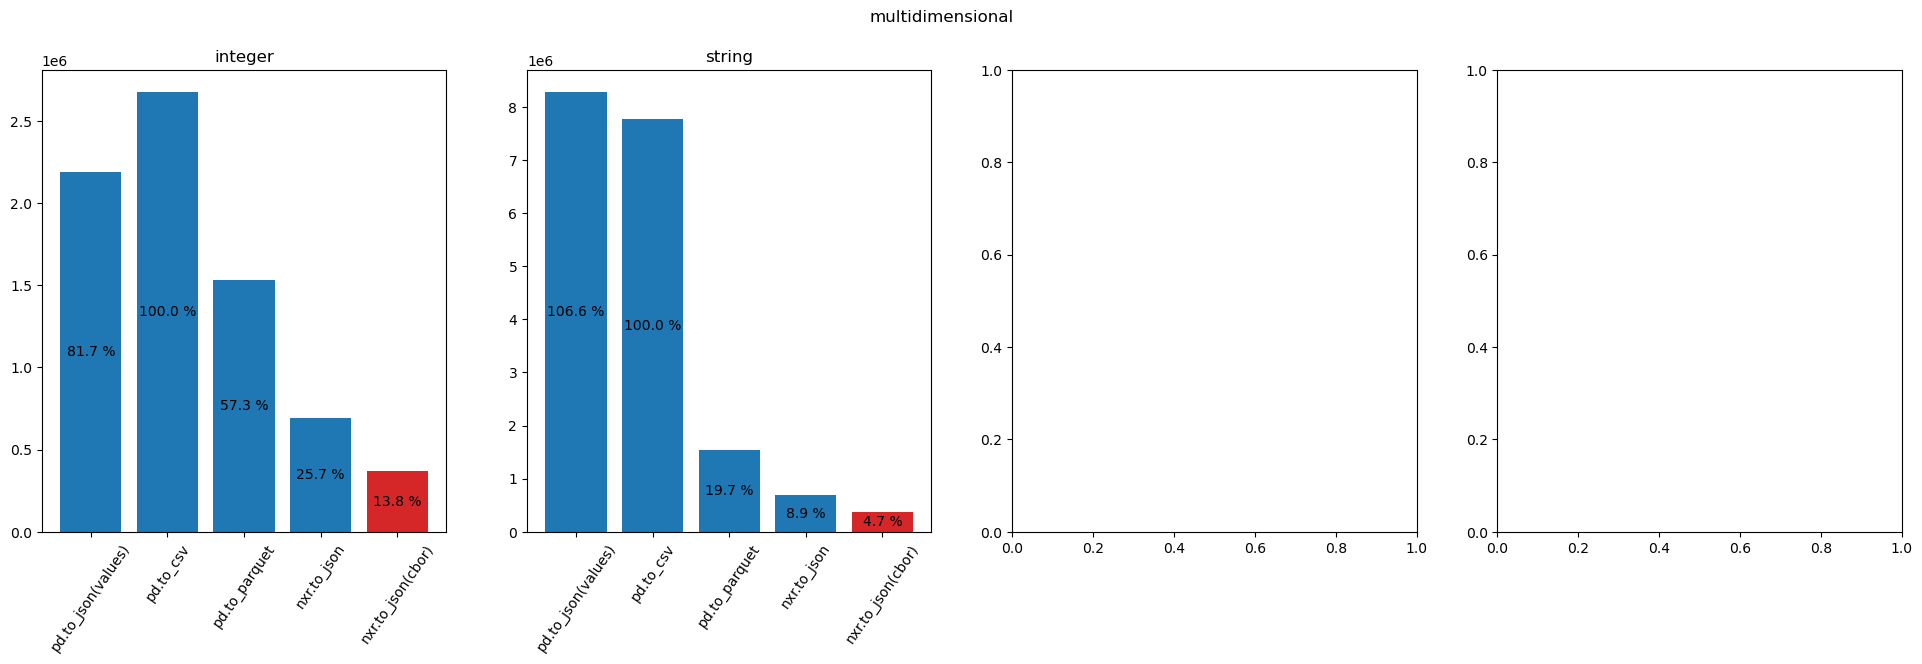

In [11]:
xnds = [Xdataset.from_xarray(xdss[0]), Xdataset.from_xarray(xdss[1])]
sizes = [file_sizes(xnd) for xnd in xnds]
titles = ['integer', 'string']
sizes_plot(sizes, titles, 'multidimensional')

In [5]:
res = []
for xds in xdss:
    xnd = Xdataset.from_xarray(xds)
    df_multi = xnd.to_dataframe(json_name=False, info=False).reset_index().sample(frac=1)
    csv = df_multi.to_csv()
    df_multi.to_csv('test_multi.csv')

    xnd = Xdataset.from_dataframe(df_multi)
    jsn_txt = xnd.to_json(notype=[True]*len(xnd), encoded=True)
    jsn = xnd.to_json(notype=[True]*len(xnd))
    #jsn = xnd.to_json(notype=[True]*len(xnd), format=['complete']*len(xnd))
    jsb = cbor2.dumps(jsn)
    
    res.append([len(jsb)/1024, len(jsn_txt)/1024, len(csv)/1024])
df_multi

,a:string,b:string,c:string,d:string,e:string,var:int32
28767,azertyazerty,ghjklmghjklm,hjklmwhjklmw,dfghjkdfghjk,zertyuzertyu,28767
13129,dfghjkdfghjk,zertyuzertyu,ghjklmghjklm,rtyuiortyuio,uiopqsuiopqs,13129
1474,sdfghjsdfghj,qsdfghqsdfgh,qsdfghqsdfgh,ghjklmghjklm,wxcvbnwxcvbn,1474
34179,zertyuzertyu,rtyuiortyuio,ghjklmghjklm,ghjklmghjklm,uiopqsuiopqs,34179
6968,sdfghjsdfghj,dfghjkdfghjk,rtyuiortyuio,dfghjkdfghjk,rtyuiortyuio,6968
...,...,...,...,...,...,...
11240,dfghjkdfghjk,qsdfghqsdfgh,azertyazerty,qsdfghqsdfgh,qsdfghqsdfgh,11240
8074,sdfghjsdfghj,ghjklmghjklm,dfghjkdfghjk,ghjklmghjklm,wxcvbnwxcvbn,8074
86533,wxcvbnwxcvbn,dfghjkdfghjk,sdfghjsdfghj,uiopqsuiopqs,ghjklmghjklm,86533
20151,azertyazerty,uiopqsuiopqs,ghjklmghjklm,sdfghjsdfghj,sdfghjsdfghj,20151


In [ ]:
res[0].append(1985.0)
res[1].append(1986.0)
res

In [ ]:
res

# tree

In [ ]:
strg = np.arange(2**2)
strg = np.frompyfunc(str, 1, 1)(strg)
strg

In [ ]:
# size = 15
size = 10
arr = np.arange(2**size)
data_int = [arr]
data_str = [np.frompyfunc(str, 1, 1)(arr)]
for i in range(size):
    arr = arr // 2
    data_int.append(arr)
    data_str.append(np.frompyfunc(str, 1, 1)(arr))
tab_int_tree = {'col_' + str(i): data_int[i] for i in range(len(data_int))}
tab_str_tree = {'col_' + str(i): data_str[i] for i in range(len(data_str))}

In [ ]:
df_int_tree = pd.DataFrame(tab_int_tree)
df_str_tree = pd.DataFrame(tab_str_tree)
df_int_tree

In [ ]:
df_int_tree = df_int_tree.sample(frac=1).reset_index(drop=True)
df_str_tree = df_str_tree.sample(frac=1).reset_index(drop=True)

In [ ]:
res_tree = []
for df in [df_int_tree, df_str_tree]:
    csv = df.to_csv()
    xnd = Xdataset.from_dataframe(df)
    jsn_full_txt = xnd.to_json(notype='all', encoded=True)
    jsn_full = xnd.to_json(notype='all')
    forma = {name:'complete' for name in xnd.names[1:]}
    jsn_comp_txt = xnd.to_json(notype='all', format=forma, encoded=True)
    jsn_comp = xnd.to_json(notype='all', format=forma)
    jsb_comp = cbor2.dumps(jsn_comp)
    
    res_tree.append([len(jsb_comp)/1024, len(jsn_comp_txt)/1024, len(jsn_full_txt)/1024, len(csv)/1024])
res_tree

In [ ]:
from time import time

df = df_int_tree
tim = [] 
tim.append(time())
csv = df.to_csv()
tim.append(time())
xnd = Xdataset.from_dataframe(df, distr=False)
tim.append(time())
jsn_full_txt = xnd.to_json(notype='all', encoded=True)
tim.append(time())
jsn_full = xnd.to_json(notype='all')
tim.append(time())
forma = {name:'complete' for name in xnd.names[1:]}
tim.append(time())
jsn_comp_txt = xnd.to_json(notype='all', format=forma, encoded=True)
tim.append(time())
jsn_comp = xnd.to_json(notype='all', format=forma)
tim.append(time())
jsb_comp = cbor2.dumps(jsn_comp)
tim.append(time())

dt = [tim[i+1] - tim[i] for i in range(len(tim)-1)]
dt
    

In [ ]:
from xconnector import PandasConnec
t0=time()
PandasConnec._ximport_analysis(df_int_tree, None, distr=True)
print(time()-t0)